In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
#! pip install spacy
#!python -m spacy download en_core_web_sm

In [7]:
## Placeholder for reading dataframe
DF = pd.read_csv("/Users/angshuman.chakraborty@cognitedata.com/Desktop/work/BP/DDRs/DDR_data_OCS2021.csv")

In [8]:
#Filtering for NPT events
DF = DF[(DF["Code"] == "N") | (DF["Code"] == "X")]

In [9]:
df = pd.DataFrame(DF,columns=["processed_operation"])

In [10]:
df = df.rename(columns = {"processed_operation":"Operation"})

In [13]:
## check linguistic annotations
sent = nlp_model("London is the biggest city in Britain")
for tok in sent:
  print(tok.text, "...", tok.dep_,"...",tok.pos_,"...",tok.lemma_)

London ... nsubj ... PROPN ... London
is ... ROOT ... AUX ... be
the ... det ... DET ... the
biggest ... amod ... ADJ ... big
city ... attr ... NOUN ... city
in ... prep ... ADP ... in
Britain ... pobj ... PROPN ... Britain


## Extraction of Entities: subjects and objects, relation extraction and building KGs

['WELLBORE OCS', 'break', '65/8  D.P.']
['WELLBORE OCS', 'make stand PSI', '32 K 18558']
['3  ATTEMPTS', 'take failed', '']
['WELLBORE OCS', 'continue circulate', 'FURTHER BP HOUSTON']
['WELLBORE OCS', 'decision make continue drill taking stand drill', 'DOWN  CONNECTIONS']
['CEMENT SPACER FINISH', 'have while rate monitor weigh string MIN prevent LBS LBS', '30 STUCK PIPE']
['WELLBORE OCS', 'loss tour loss bbl', 'TOTAL  TOUR']
['WELLBORE OCS', 'metal RECOVERED magnets recover', '0.0 LBS TOTAL 121/4']
['WELLBORE OCS', 'UNABLE function', 'CURRENT TEST CROWN OPERATIONS']
['WELLBORE OCS', 'continue while', 'TRIP TANK']
['BBLS HR LOSS WHILE', 'rate monitor', '']
['WELLBORE OCS', 'MIN prevent LBS LBS', '30 STUCK PIPE']
['WELLBORE OCS', 'hold PJSM', '']
['WELLBORE OCS', 'break stand', 'KELLY 37']
['WELLBORE OCS', 'TDX pull', 'FT PUMP MIN']
['WELLBORE OCS', 'observe increase', '5 BBLS PUMPED']
['WELLBORE OCS', 'SHUT hold', 'PRESSURE 1500']
['WELLBORE OCS', 'continue pull stand make', '2 BLEED O

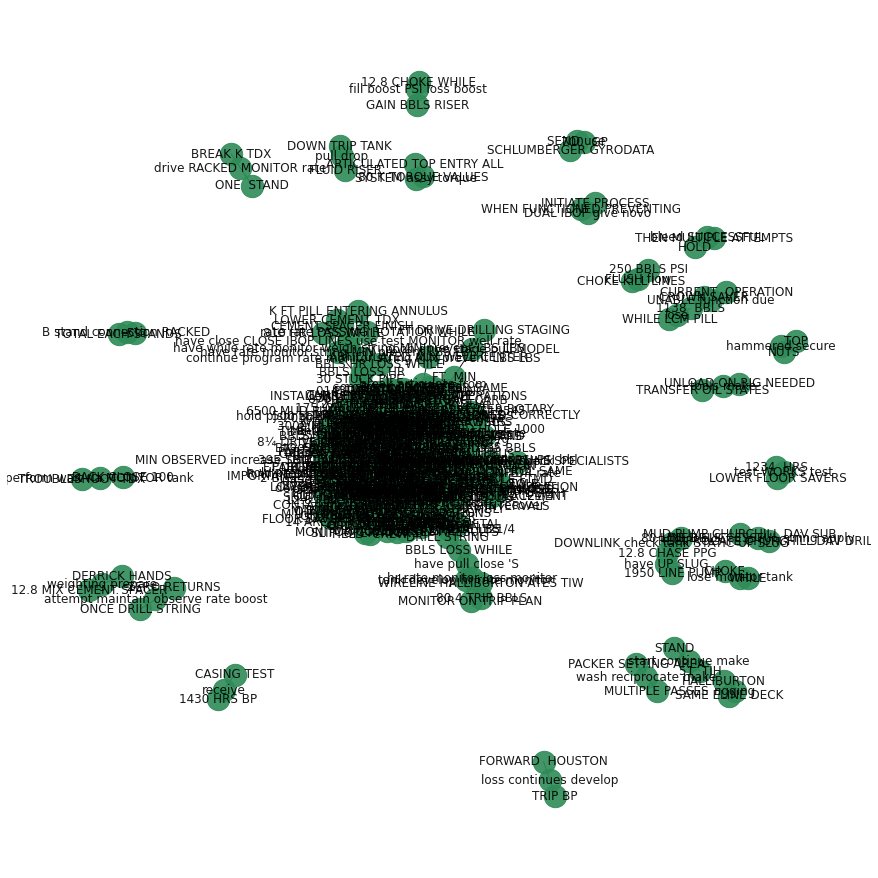

In [12]:
import networkx as nx
import spacy
from spacy import displacy
from spacy.tokens import Span 

#Checks if token is a possible relation
def checkRelationCandidate(tok):
    deps = ["ROOT", "adj", "attr", "agent"] #attr: attributes
    pos = ["VERB"]
    return any(subs in tok.dep_ for subs in deps) | any(subs in tok.pos_ for subs in pos)

def processSubjectObjectPairs(tokens):
  ## defining variables
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence
  # prv_tok_pos = ""    # previous pos in the sentence
  prefix = ""
  modifier = ""
  relation = ''
  
  for tok in tokens:
    ## Looping through tokens
    if checkRelationCandidate(tok):
      relation = relation + " " + tok.lemma_
      
      # if prv_tok_pos == "VERB":
      #   relation = appendChunk(prv_tok_text,relation)


    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      #check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## If token is a subject - capture it as first entity
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## If token is a obj - capture it as second entity
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
        
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
      # prv_tok_pos = tok.pos_

  #return (subject.strip(), relation.strip(), object.strip())
  print([ent1.strip(), relation.strip(),ent2.strip()])
  return [ent1.strip(), relation.strip(),ent2.strip()]

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)


# Building KGs: Creating a directed graph from the dataframe -  Plots all relations in the dataframe
def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(12,12))
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    
    nlp_model = spacy.load('en_core_web_sm')

    triples = []
    
    for sentence in df["Operation"]:
        triples.append(processSentence(sentence))

    printGraph(triples)
